In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils

## (1) Prepare Data

In [3]:
PRIME = 5
CHAR_BY_ID = {0: 'a', 1: 'c', 2: 'b', 3: 'e', 4: 'd',}
HOLDOUT_SET = ['a#c=', 'c#a=', 'd#b=', 'd#c=', 'e#d=']
XRANGE = (0, PRIME)
YRANGE = (0, PRIME)

def binary_operation(x, y):
    return (x**2 + y**2 + x*y + x) % PRIME

In [4]:
def get_data_as_table(data, ground_truth_data = None, title = None):
    table = pd.DataFrame('',
                         index=sorted([CHAR_BY_ID[i] for i in range(*XRANGE)]),
                         columns=sorted([CHAR_BY_ID[i] for i in range(*YRANGE)]))
    for expr in data:
        result = data[expr]
        if ground_truth_data is not None and expr in ground_truth_data:
            correct_result = ground_truth_data[expr]
            result += (' ✅' if result == correct_result else ' ❌')
        (x, y) = expr[:-1].split('#')
        table.loc[x, y] = result
    if title is not None:
        table.columns.name = title
    return table


train_data = {}
test_data = {}
for x in range(*XRANGE):
    for y in range(*YRANGE):
        expr = f'{CHAR_BY_ID[x]}#{CHAR_BY_ID[y]}='
        result = CHAR_BY_ID[binary_operation(x, y)]
        if expr in HOLDOUT_SET:
            test_data[expr] = result
        else:
            train_data[expr] = result

train_table = get_data_as_table(train_data)
test_table = get_data_as_table(test_data)

## (2) Experiment Summary

> We reproduce OpenAI's Grokking paper, [Grokking: Generalization Beyond Overfitting on Small Algorithmic Datasets, Power et all. 2022](https://arxiv.org/abs/2201.02177).
> 
>  In particular, we train on the 5x5 binary operation table in Figure 1 that looks like this:

In [5]:
candle.utils.display_sbs(train_table.style.set_caption('Train'), test_table.style.set_caption('Test'), margin=60)

,a,b,c,d,e
a,a,d,,c,d
b,c,d,d,a,c
c,,e,d,b,d
d,a,,,b,c
e,b,b,c,,a
,a,b,c,d,e
a,,,c,,
b,,,,,
c,b,,,,
d,,b,a,,


> The solution to this binary operation table is $f(x, y)=x^2 + y^2 + xy + x \pmod 5$, and $(a, b, c, d, e) = (0, 2, 1, 4, 3)$.
> 
> (When reading the paper, I got totally nerd sniped by `We invite the reader to make their guesses as to which elements are missing`. It took me >30min to fill in the correct symbols, >2hrs to guess the exact functional form. Let's see how fast a transformer can do it 😉)

## (3) Set up Model and Optimizer

In [6]:
class Config:
    # Optimization configs
    
    ITERATIONS = 200_000
    BATCH_SIZE = min(512, len(train_data) // 2)
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1.0
    ADAM_BETAS = (0.9, 0.98)
    DASHBOARD_REFRESH_ITERS = 100
    
    # LR scheduler configs
    WARMUP_STEPS = 10
    
    # Model architecture configs
    
    NUM_LAYERS = 2
    NUM_HEADS = 4
    EMBED_DIM = 128
    DROPOUT = 0.1
    
config = Config()

In [7]:
class Tokenizer:
    def __init__(self, char_by_id, prime):
        self.char_by_id = char_by_id.copy()
        self.char_by_id[prime] = '#'
        self.char_by_id[prime + 1] = '='
        self.id_by_char = {v: k for (k, v) in self.char_by_id.items()}
        self.id_by_char['-'] = -1
        self.vocab_size = len(self.char_by_id)
    
    def encode(self, text):
        return [self.id_by_char[c] for c in text]
    
    def decode(self, indices):
        return ''.join([self.char_by_id[idx] for idx in indices])  

In [8]:
tokenizer = Tokenizer(CHAR_BY_ID, PRIME)

model = candle.models.gpt.GPT(n_layers=config.NUM_LAYERS,
                              n_heads=config.NUM_HEADS,
                              embed_dim=config.EMBED_DIM,
                              vocab_size=tokenizer.vocab_size,
                              block_size=5,
                              dropout_p=config.DROPOUT)
model.init_weights()

optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY,
                                   betas=config.ADAM_BETAS)

scheduler = candle.scheduler.WarmupWrapper(candle.scheduler.StepLR(optimizer,
                                                                   step_size=10_000_000,
                                                                   gamma=1.0),  # No StepLR
                                           warmup_steps=config.WARMUP_STEPS)

model.summary(input_shape=(1, 4))

Layer Type # Parameters Output Shape
                                                             
decoder_blocks      0  DecoderBlock       198272  (1, 4, 128)
                    1  DecoderBlock       198272  (1, 4, 128)
dropout                     Dropout            0  (1, 4, 128)
layer_norm                LayerNorm          256  (1, 4, 128)
output_projection         Parameter          896         None
position_embeddings       Embedding          640     (4, 128)
word_embeddings           Embedding          896  (1, 4, 128)
Total                                     398336

## (5) Train Model

In [9]:
# Initialize dashboard

writer = candle.Dashboard()
writer.change_settings('figsize', (5, 3.5))
writer.change_settings('xscale', 'log')
writer.change_settings('xscale_logbase', 10)
for label in ['Parameter', 'Gradient', 'Update', 'Adam Variance']:
    writer.change_settings('xlim', (-10, np.inf), chart_label=f'log({label})')
    writer.change_settings('yscale', 'log', chart_label=f'{label} Norm by Layer')

In [10]:
# Initialize DataLoader

X_train = candle.Tensor([tokenizer.encode(expr) for expr in train_data.keys()])
y_train = candle.Tensor([tokenizer.encode(expr)[0] for expr in train_data.values()])
X_test = candle.Tensor([tokenizer.encode(expr) for expr in test_data.keys()])
y_test = candle.Tensor([tokenizer.encode(expr)[0] for expr in test_data.values()])

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
data_iterator = iter(data_loader)

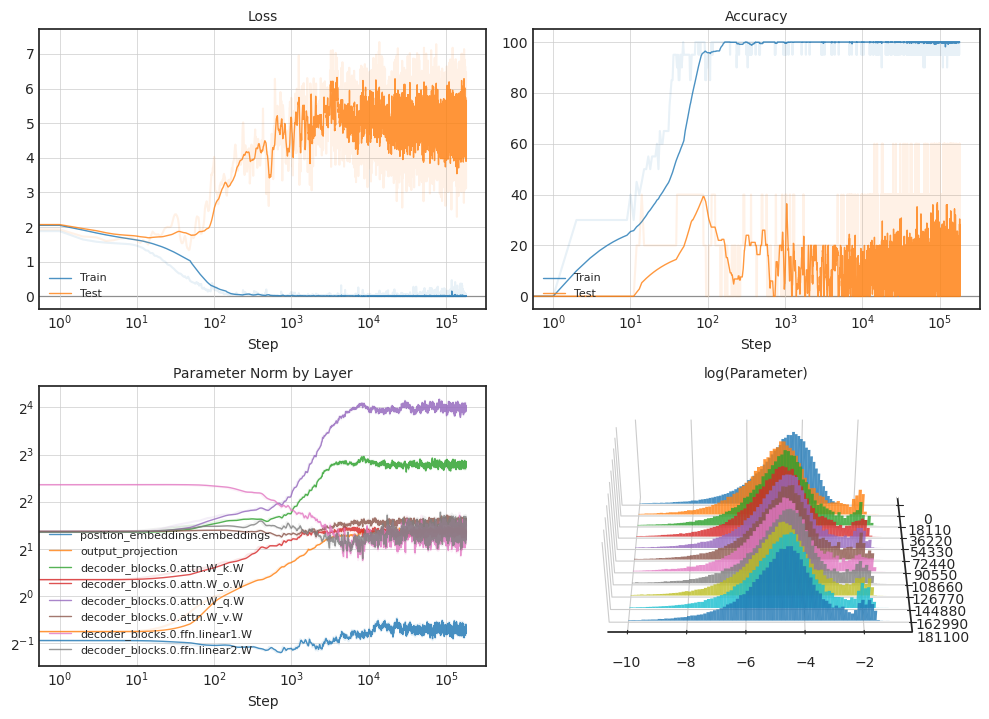

,a,b,c,d,e
a,a,d,,c,d
b,c,d,d,a,c
c,,e,d,b,d
d,a,,,b,c
e,b,b,c,,a
,a,b,c,d,e
a,a ✅,d ✅,,c ✅,d ✅
b,c ✅,d ✅,d ✅,a ✅,c ✅
c,,e ✅,d ✅,b ✅,d ✅
d,a ✅,,,b ✅,c ✅


In [ ]:
for iteration in range(config.ITERATIONS):
    model.train()
    
    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)
    
    optimizer.zero_grad()
    output = model(X_batch)[:, -1]  # Only compute loss on the last element
    loss = F.cross_entropy_loss(output, y_batch)
    loss.backward()
    
    optimizer.step()
    scheduler.step()
    
    # -----------------
    # Visualize metrics
    # -----------------

    with candle.no_grad():
        model.eval()
        
        params_to_track = [
            'position_embeddings.embeddings',
            'output_projection',
            'decoder_blocks.0.attn.W_k.W',
            'decoder_blocks.0.attn.W_o.W',
            'decoder_blocks.0.attn.W_q.W',
            'decoder_blocks.0.attn.W_v.W',
            'decoder_blocks.0.ffn.linear1.W',
            'decoder_blocks.0.ffn.linear2.W',
        ]
        (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
        (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
        (updates, upd_by_layer, upd_norm_by_layer) = tutils.get_adam_updates(params_to_track, optimizer)
        (adam_var, adam_var_by_layer, adam_var_norm_by_layer) = tutils.get_adam_var(params_to_track, optimizer)
        (adam_mom, adam_mom_by_layer, adam_mom_norm_by_layer) = tutils.get_adam_mom(params_to_track, optimizer)
        
        corr_grad_mom_by_layer = {
            name: np.corrcoef(grad_by_layer[name].flatten(),
                              adam_mom_by_layer[name].flatten())[0, 1]
            for name in params_to_track
        }
        
        train_output = model(X_train)[:, -1]
        (train_loss, train_acc) = tutils.get_loss_and_accuracy(model, X_train, y_train, train_output.data)
        writer.add_scalars('Loss', {'Train': train_loss})
        writer.add_scalars('Accuracy', {'Train': train_acc})
        
        test_output = model(X_test)[:, -1]
        (test_loss, test_acc) = tutils.get_loss_and_accuracy(model, X_test, y_test, test_output.data)
        writer.add_scalars('Loss', {'Test': test_loss}, iteration)
        writer.add_scalars('Accuracy', {'Test': test_acc}, iteration)
        
        writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
        writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
        
        if (iteration % config.DASHBOARD_REFRESH_ITERS == 0) or (iteration < 500 and iteration % 5 == 0):
            # Display prediction tables
            test_predictions = model(X_test)[:, -1]
            test_predictions = np.argmax(test_predictions.data, axis=1)
            test_predictions = list(tokenizer.decode(test_predictions))
            test_prediction_data = dict(zip(test_data.keys(), test_predictions))
            test_prediction_table = get_data_as_table(test_prediction_data, test_data)
            
            train_predictions = model(X_train)[:, -1]
            train_predictions = np.argmax(train_predictions.data, axis=1)
            train_predictions = list(tokenizer.decode(train_predictions))
            train_prediction_data = dict(zip(train_data.keys(), train_predictions))
            train_prediction_table = get_data_as_table(train_prediction_data, train_data)
            
            writer.plot(clear_output=True)
            candle.utils.display_sbs(train_table.style.set_caption('Train'),
                                     train_prediction_table.style.set_caption('Train Predictions'),
                                     test_table.style.set_caption('Test'),
                                     test_prediction_table.style.set_caption('Test Predictions'),
                                     margin=65)
            
        if test_acc >= 99.0 and iteration % 10000 == 0:
            break

## (6) Conclusion
> Unfortunately, no matter what hyperparameters or iteration budget, I could not obtain generalization on the 5x5 table. Proof that humans are still smarter 😉